<a href="https://colab.research.google.com/github/changliu8888/ML-/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from scipy.stats import uniform
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Import distribution uniform

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


array([[<Axes: title={'center': 'item'}>]], dtype=object)

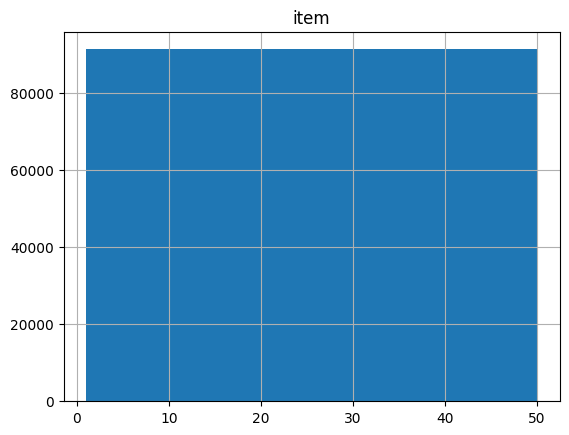

In [ ]:
train.hist('item')

<Axes: >

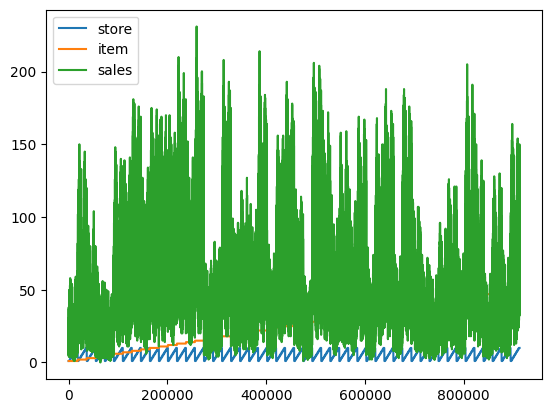

In [ ]:
train.plot()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


### Check for Null values

In [ ]:
 store_sales=train.drop(['store','item'],axis=1)
 store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
#convert data_time
store_sales['date']=pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


## Converting date to month period, and sum the numbers in each **month**

In [ ]:
store_sales['date']=store_sales['date'].dt.to_period('M')
monthly_sales=store_sales.groupby('date').sum().reset_index()
monthly_sales.head()

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


In [ ]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [ ]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


<Axes: >

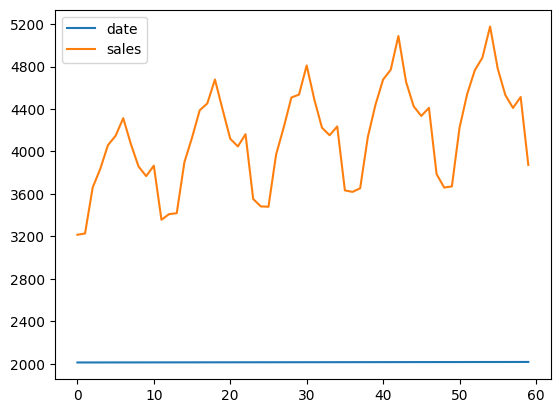

In [ ]:
monthly_sales.plot()

## https://youtu.be/20fbgWm5M2o?si=T_RljxGQI7Ps1yH_  16:**33**

Text(0, 0.5, 'Sales')

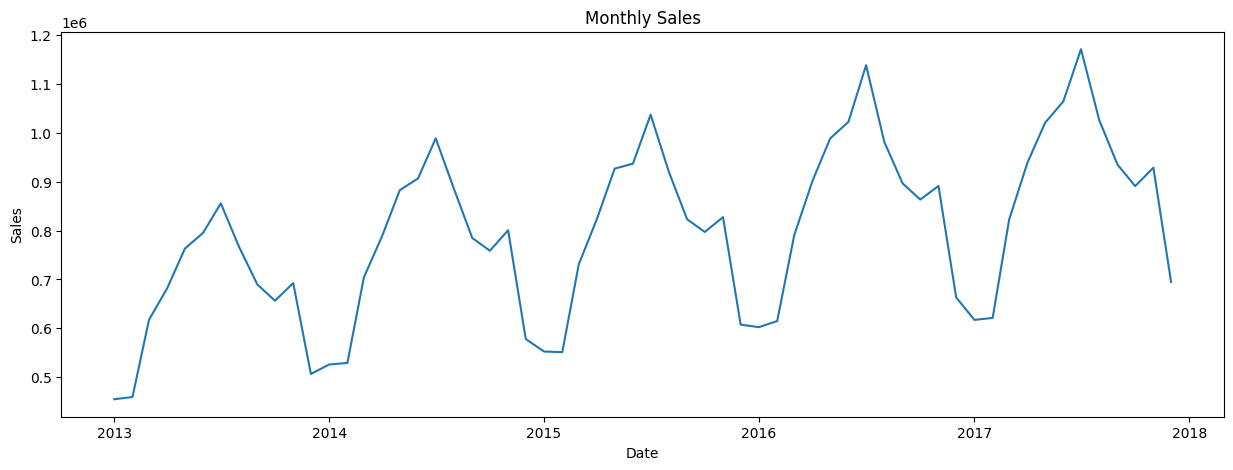

In [ ]:
plt.figure(figsize=(15,5 ))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

<Axes: xlabel='date'>

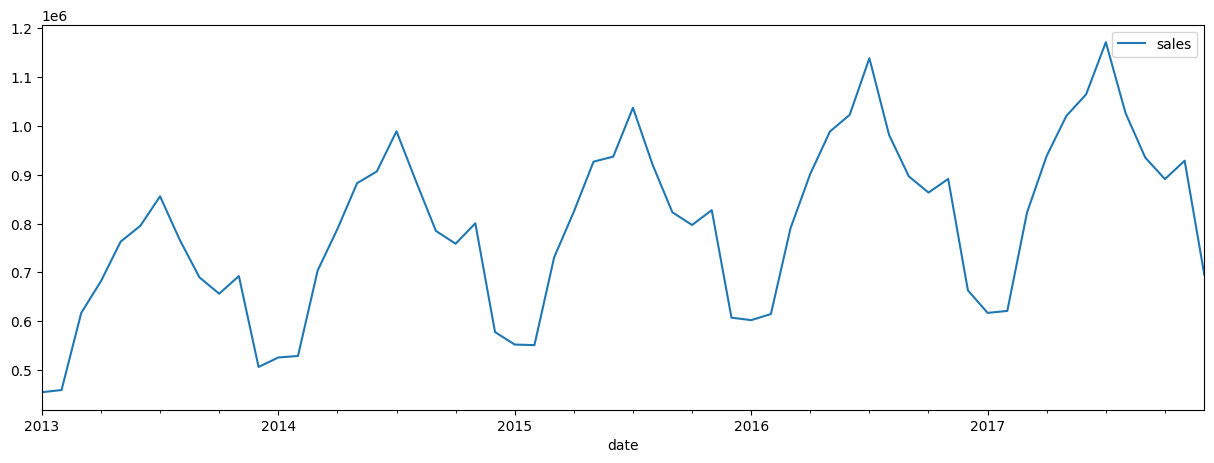

In [ ]:
monthly_sales.plot('date','sales',figsize=(15,5))

<Axes: xlabel='date'>

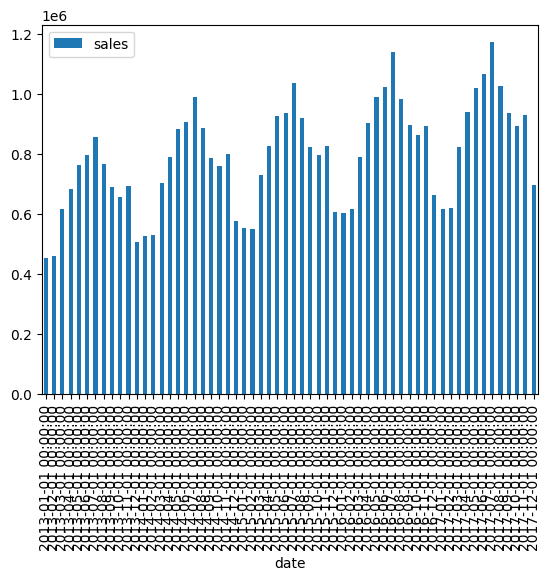

In [ ]:
monthly_sales.plot.bar('date','sales')

## Prepare the data by stabilizing it with differences; Training supervised dataset

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()
#dropping off sales and date
supervised_data = monthly_sales.drop(['sales','date'], axis=1)
supervised_data.head()

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0


In [ ]:
supervised_data.describe()

,sales_diff
count,59.000000
mean,4072.305085
std,107306.930598
min,-233667.000000
25%,-61479.500000
50%,19380.000000
75%,83390.500000
max,201298.000000


array([[<Axes: title={'center': 'sales_diff'}>]], dtype=object)

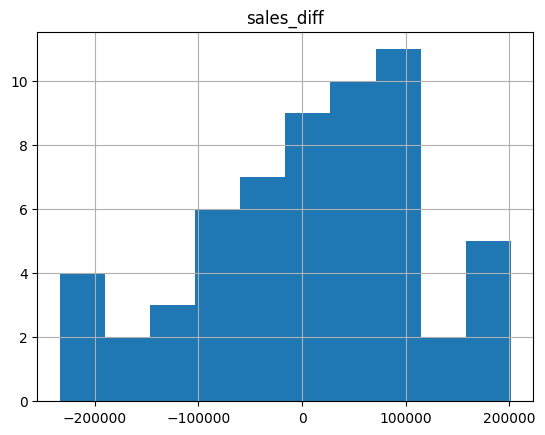

In [ ]:
supervised_data.hist()

In [ ]:
for i in range(1,13):
    col_name = 'month' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
# some kind of concatenate and making some into null

In [ ]:
supervised_data.head(13)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN
8,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN
9,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN
10,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN


In [ ]:
supervised_data.head(30)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN
8,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN
9,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN
10,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN


In [ ]:
supervised_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales_diff  59 non-null     float64
 1   month1      58 non-null     float64
 2   month2      57 non-null     float64
 3   month3      56 non-null     float64
 4   month4      55 non-null     float64
 5   month5      54 non-null     float64
 6   month6      53 non-null     float64
 7   month7      52 non-null     float64
 8   month8      51 non-null     float64
 9   month9      50 non-null     float64
 10  month10     49 non-null     float64
 11  month11     48 non-null     float64
 12  month12     47 non-null     float64
dtypes: float64(13)
memory usage: 6.5 KB


In [ ]:
supervised_data.tail(20)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
40,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0
41,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0
42,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0,-97069.0,-116949.0,100166.0
43,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0,-97069.0,-116949.0
44,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0,-97069.0
45,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0,-26079.0
46,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0,30392.0
47,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0,-220073.0
48,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0
49,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0


In [ ]:
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(20)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype    
---  ------  --------------   -----    
 0   date    913000 non-null  period[M]
 1   sales   913000 non-null  int64    
dtypes: int64(1), period[M](1)
memory usage: 13.9 MB


In [ ]:
#27.46
# split data to train and test
train_data = supervised_data.iloc[:-12]
test_data = supervised_data.iloc[-12:]
print('Train data shape:',train_data.shape)
print(test_data.shape)
supervised_data.shape

Train data shape: (35, 13)
(12, 13)


(47, 13)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


In [ ]:
x_train, y_train = scaled_train_data[:,1:], scaled_train_data[:,0:1]
x_test, y_test = scaled_test_data[:,1:], scaled_test_data[:,0:1]
#first column is output
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape:',x_train.shape)
print('y_train shape:',y_train.shape)
print('x_test shape:',x_test.shape)
print('y_test shape:',y_test.shape)


x_train shape: (35, 12)
y_train shape: (35,)
x_test shape: (12, 12)
y_test shape: (12,)


In [ ]:
# last step of data preprocessing
# make prediction data frame to merge the predicted sales prices
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame({'date':sales_dates})
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


## Now we begin linear regression **bold text**

In [ ]:
# to create linear regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
 lr_pre = lr_pre.reshape(-1,1)
 # set matrix contain input features and predicted output
 lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
 lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list = []
for i in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[i][0]+act_sales[i])
lr_pre_series = pd.Series(result_list, name='Linear Prediction')
# seems very important to use the word Linear Prediction precisely 4908
predict_df = predict_df.merge(lr_pre_series,left_index=True, right_index=True)

In [ ]:
predict_df.head()

,date,Linear Prediction
0,2017-01-01,6.479148e+05
1,2017-02-01,6.283374e+05
2,2017-03-01,8.195190e+05
3,2017-04-01,9.436391e+05
4,2017-05-01,1.033653e+06


In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print ('Linear Regression MSE: ', lr_mse)
print ('Linear Regression MAE: ', lr_mae)
print ('Linear Regression R2: ', lr_r2)

Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.9906152516380969


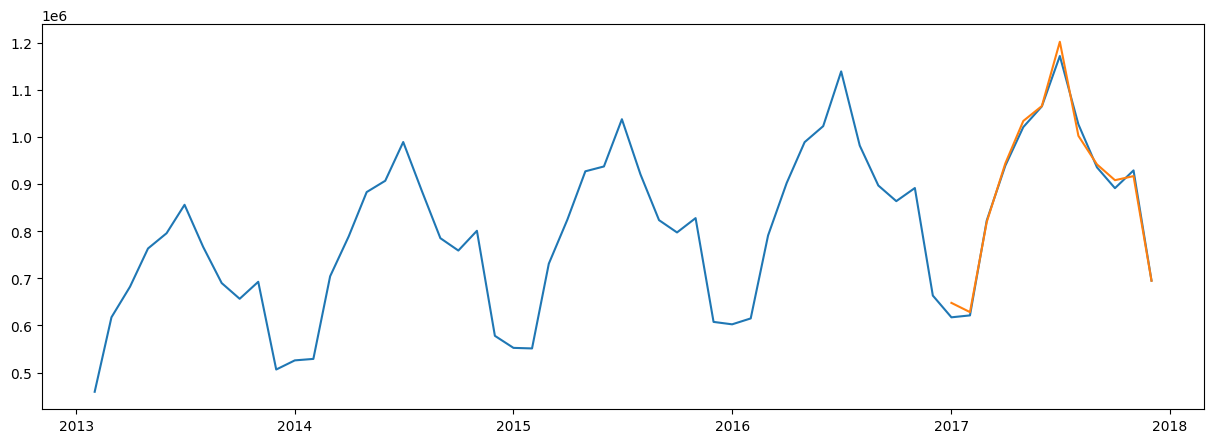

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])